In [1]:
## This script is to calculate the rain climatology 18 hour selected days
## calculate the rain distribution from the domain
## Created by C. Bayu Risanto, S.J. (18 June 2024)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import matlib
import os
from os.path import exists
import xarray as xr
from scipy.stats import norm,skewnorm
import scipy as sc
import math as mt
import dateutil.parser
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
from copy import copy
from scipy import stats
import shapely.geometry as sgeom
from datetime import date, datetime, timedelta

# create ncfile opener
def read_nc(link,ncfile):
    fname = link + ncfile
    ds = xr.open_dataset(fname)
    pcp = ds.PRECIP[:,:,:]
    return pcp
def read_latlon_mrms(link,ncfile):
    fname = link + ncfile
    ds = xr.open_dataset(fname)
    lat = ds.lat_0[:]
    lon = ds.lon_0[:]
    return lat,lon
def date_range_list(start_date, end_date):
    # Return list of datetime.date objects (inclusive) between start_date and end_date (inclusive).
    date_list = []
    curr_date = start_date
    while curr_date <= end_date:
        date_list.append(curr_date)
        curr_date += timedelta(days=1)
    return date_list

In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-28','2021-08-30','2021-08-31',
      '2021-09-01']

In [3]:
## create day times
daystrform = '%Y-%m-%d'
daySta = [datetime.strptime(DR[i],daystrform) for i in range(len(DR))]
dayEnd = [(datetime.strptime(DR[i],daystrform)) + timedelta(days=1) for i in range(len(DR))]


In [4]:
## read data
PCP_AL = []
for itime in range(len(DR)):
    day_st = str(daySta[itime])[0:10]
    day_en = str(dayEnd[itime])[0:10]
    datestrform = '%Y-%m-%dT%H'
    date_st = datetime.strptime(day_st + 'T18',datestrform)
    date_en = datetime.strptime(day_en + 'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

    ## Crop 
    #min_lat = 31.2
    #max_lat = 37
    #min_lon = 245
    #max_lon = 251

    ## hourly precip and save the dates and hours
    link = '/net/brisa/br1/castrogroup/bayu/DYLAN-DATA/MRMS/ncfiles/'
    pcp_hr_al = []
    for i in range(len(dateList)):
        yy = str(dateList[i]); YYYY = yy[0:4]
        mm = str(dateList[i]); MM = mm[5:7]
        dd = str(dateList[i]); DD = dd[8:10]
        hh = str(dateList[i]); HH = hh[11:13]
        nc_hour = 'MultiSensor_QPE_01H_Pass2_00.00_'+YYYY+MM+DD+'-'+HH+'0000_AZ.nc'
        if exists(link + nc_hour) == True:
            pcp_hr = read_nc(link,nc_hour)
            #new = pcp_hr.sel(lat_0=slice(min_lat,max_lat),lon_0=slice(min_lon,max_lon)) ##crop here
            pcp_hr_al.append(np.squeeze(pcp_hr))
        al_pcp_hr = np.asarray(pcp_hr_al)
    PCP_AL.append(al_pcp_hr)
PCP_4D = np.asarray(PCP_AL)

In [5]:
print(PCP_4D.shape)

(25, 19, 651, 612)


In [6]:
## calculate total 18 hours and MEAN (clima)
day_PCP = np.sum(PCP_4D,axis=1)
muday_PCP = np.mean(day_PCP,axis=0)  #clima 18hr

In [7]:
## make one dimension and clean from nan (hourly)
RAIN_1d = muday_PCP.flatten() 
RAIN_1ds = np.sort(RAIN_1d)

R_1ds = [x for x in RAIN_1ds if x > 0] ## get non zero
R_1ds = np.asarray(R_1ds)

In [8]:
### calculate histogram
n_bins = 100
hist_R1ds = np.histogram(R_1ds,bins=n_bins); #print(hist_R1ds[0])
number = hist_R1ds[0]
amount = hist_R1ds[1]
numevents = np.sum(number)

## normalize
Freq = (number/numevents)*100 ; #print(Freq)  

## calculate Point percent Func
p1 = np.round(np.percentile(R_1ds,90),2);#print(p1)
p2 = np.round(np.percentile(R_1ds,95),2);#print(p2)

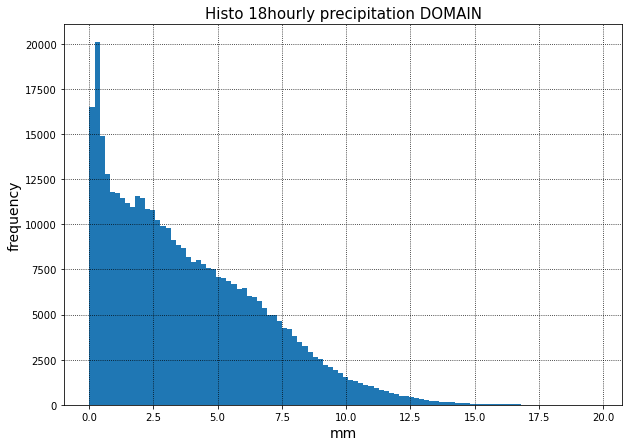

In [9]:
## plot histogram
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(R_1ds,bins=n_bins)
ax.grid(color='black', linestyle='dotted')
ax.set_xlabel('mm',fontsize=14)
ax.set_ylabel('frequency',fontsize=14)
ax.set_title('Histo 18hourly precipitation DOMAIN',fontsize=15)

plt.show()
plt.close()

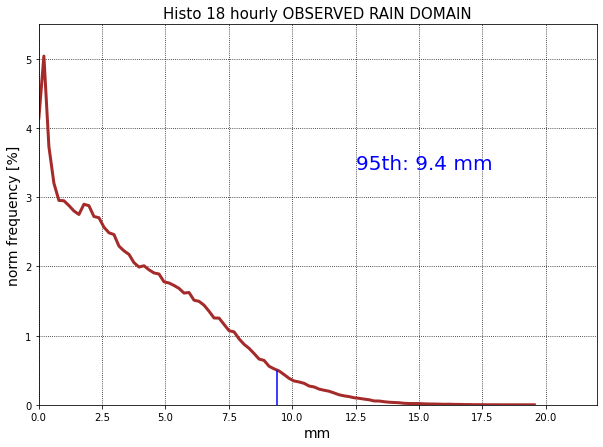

In [18]:
## plot histogram
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(amount[0:-1],Freq,'brown',lw=3)

#ax.axvline(p1,ymax=0.16,color='r')
ax.axvline(p2,ymax=0.09,color='b')

ax.set_xlim(0,22)
ax.set_ylim(0,5.5)
ax.grid(color='black', linestyle='dotted')
ax.set_xlabel('mm',fontsize=14)
ax.set_ylabel('norm frequency [%]',fontsize=14)
ax.set_title('Histo 18 hourly OBSERVED RAIN DOMAIN',fontsize=15)
#ax.annotate('90th: '+str(p1)+' mm',xy=(12.5,3.8),xytext=(12.5,3.8),fontsize=20,color='r')
ax.annotate('95th: '+str(p2)+' mm',xy=(12.5,3.4),xytext=(12.5,3.4),fontsize=20,color='b')

## SAVE
dir_out = '/home/bayu/Documents/ARIZONA-WRF/PLOTS/RAINNC_EXPS/CLIMA/'
plotfile  = 'HISTO_18hourly_precip_DOMAIN_AZ+.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [11]:
## Calculate 3 hourly 
t3RAIN = []
c = 0
for i in range(0,6,1):
    p3h = np.nansum(PCP_4D[:,c:c+4,:,:],axis=1) # 3-hour total
    t3RAIN.append(p3h)
    c = c + 3
t3RAIN = np.asarray(t3RAIN) 
mt3RAIN = np.mean(t3RAIN,axis=1) ; # mean across cases

## choose time and flatten
t3_FREQ = []
t3_AMOUNT = []
t3p1 = []
t3p2 = []
for ip in range(6):
    t3RAIN_1d = mt3RAIN[ip,:,:].flatten()
    t3RAIN_1ds = np.sort(t3RAIN_1d)
    t3R_1ds = [x for x in t3RAIN_1ds if x > 0] ## get non zero grids
    t3R_1ds = np.asarray(t3R_1ds)
    n_bins = 100
    t3hist_R1ds = np.histogram(t3R_1ds,bins=n_bins); #print(hist_R1ds[0])
    t3number = t3hist_R1ds[0]
    t3amount = t3hist_R1ds[1] ;
    t3numevents = np.sum(t3number)

## normalize
    t3Freq = (t3number/t3numevents)*100 ; #print(Freq)
## append
    t3_FREQ.append(t3Freq)
    t3_AMOUNT.append(t3amount)
    
## Calculate point percent func
    p1_t3 = np.round(np.percentile(t3R_1ds,90),1)
    p2_t3 = np.round(np.percentile(t3R_1ds,95),1)
    t3p1.append(p1_t3)
    t3p2.append(p2_t3)
    
t3_FREQ = np.asarray(t3_FREQ)
t3_AMOUNT = np.asarray(t3_AMOUNT)
t3p1 = np.asarray(t3p1)
t3p2 = np.asarray(t3p2)

In [12]:
print(t3p1)

[1.6 2.8 2.8 2.3 1.9 1.4]


In [13]:
## Create time manually 3 hourly
m_time = ['18Z-21Z','21Z-00Z','00Z-03Z','03Z-06Z','06Z-09Z','09Z-12Z']

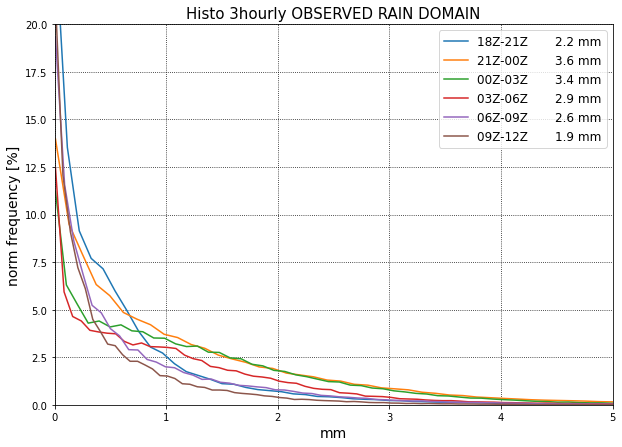

In [19]:
## plot histogram 3 hourly #####
fig, ax = plt.subplots(1,1,figsize=(10,7))
for ip in range(6):
    #ax.plot(t3_AMOUNT[ip,0:-1],t3_FREQ[ip,:],label=m_time[ip]+'      '+str(t3p1[ip])+'    '+str(t3p2[ip]) )
    ax.plot(t3_AMOUNT[ip,0:-1],t3_FREQ[ip,:],label=m_time[ip]+'       '+str(t3p2[ip])+ ' mm' )
ax.grid(color='black', linestyle='dotted')
ax.set_xlabel('mm',fontsize=14)
ax.set_ylabel('norm frequency [%]',fontsize=14)
ax.set_xlim(0,5)
ax.set_ylim(0,20)
ax.set_title('Histo 3hourly OBSERVED RAIN DOMAIN',fontsize=15)
plt.legend(loc='upper right',fontsize=12)

## SAVE
dir_out = '/home/bayu/Documents/ARIZONA-WRF/PLOTS/RAINNC_EXPS/CLIMA/'
plotfile  = 'HISTO_3hourly_precip_DOMAIN_AZ+.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()